# Graph Representations of OpenCL programs

In [3]:
# Preamble.
import collections
import contextlib
import multiprocessing
import pathlib
import typing
import time
import random

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

from labm8 import humanize

import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
from labm8 import app
from labm8 import app
from graph_nets.demos import models as gn_models

from datasets.opencl.device_mapping import opencl_device_mapping_dataset
from deeplearning.clgen.corpuses import atomizers
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import base
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import ncc
from deeplearning.ncc import task_utils as inst2vec_utils
from deeplearning.ncc import vocabulary as inst2vec_vocabulary
from experimental.compilers.reachability import llvm_util
from deeplearning.deeptune.opencl.heterogeneous_mapping import heterogeneous_mapping
from deeplearning.deeptune.opencl.heterogeneous_mapping import utils
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import models
from labm8 import logutil
from labm8 import prof
from labm8 import viz

flags.FLAGS(['argv[0]'])

%matplotlib inline

In [2]:
with prof.ProfileToStdout('read dataset'):
    dataset = opencl_device_mapping_dataset.OpenClDeviceMappingsDataset()
    df = utils.AddClassificationTargetToDataFrame(dataset.df, 'amd_tahiti_7970')
df

read dataset in 0.433 seconds (started now)


,program:benchmark_suite_name,program:benchmark_name,program:opencl_kernel_name,program:opencl_src,data:dataset_name,param:amd_tahiti_7970:wgsize,param:nvidia_gtx_960:wgsize,feature:mem,feature:comp,feature:localmem,...,feature:atomic,feature:rational,feature:amd_tahiti_7970:transfer,feature:nvidia_gtx_960:transfer,runtime:intel_core_i7_3820,runtime:amd_tahiti_7970,runtime:nvidia_gtx_960,target_gpu_name,y,y_1hot
0,amd-app-sdk-3.0,BinomialOption,binomial_options,"__kernel void A(int a, const __global float4* ...",default,255,255,13,98,11,...,0,8,2048,2048,3.291073,1.443983,0.152038,amd_tahiti_7970,1,"[0, 1]"
1,amd-app-sdk-3.0,BitonicSort,bitonicSort,"__kernel void A(__global uint* a, const uint b...",default,256,256,6,12,0,...,0,2,131072,131072,0.121940,0.279521,0.057834,amd_tahiti_7970,0,"[1, 0]"
2,amd-app-sdk-3.0,BlackScholes,blackScholes,"__kernel void A(const __global float4* a, int ...",default,256,256,3,220,0,...,0,4,3145728,3145728,6.076052,2.740855,1.997728,amd_tahiti_7970,1,"[0, 1]"
3,amd-app-sdk-3.0,FastWalshTransform,fastWalshTransform,"__kernel void A(__global float* a, __const int...",default,256,256,4,8,0,...,0,0,4096,4096,0.130003,0.668892,0.062024,amd_tahiti_7970,0,"[1, 0]"
4,amd-app-sdk-3.0,FloydWarshall,floydWarshallPass,"__kernel void A(__global uint* a, __global uin...",default,256,256,5,11,0,...,0,1,524288,524288,0.283447,0.769755,0.604686,amd_tahiti_7970,0,"[1, 0]"
5,amd-app-sdk-3.0,MatrixMultiplication,mmmKernel,"__kernel void A(__global float4* a, __global f...",default,64,64,12,163,0,...,0,1,49152,49152,0.277644,1.120132,0.124211,amd_tahiti_7970,0,"[1, 0]"
6,amd-app-sdk-3.0,MatrixTranspose,matrixTranspose,"__kernel void A(__global float4* a, __global f...",default,256,256,16,42,8,...,0,0,32768,32768,0.156639,1.009519,0.087846,amd_tahiti_7970,0,"[1, 0]"
7,amd-app-sdk-3.0,PrefixSum,group_prefixSum,"__kernel void A(__global float* a, __global fl...",default,640,1024,12,36,8,...,0,10,4096,4096,0.484234,0.847908,0.049376,amd_tahiti_7970,0,"[1, 0]"
8,amd-app-sdk-3.0,Reduction,reduce,"__kernel void A(__global uint4* a, __global ui...",default,256,256,7,6,4,...,0,3,8208,8208,0.161025,0.887437,0.070912,amd_tahiti_7970,0,"[1, 0]"
9,amd-app-sdk-3.0,ScanLargeArrays,ScanLargeArrays,"__kernel void A(__global float* a, __global fl...",default,128,128,21,32,14,...,0,3,263168,263168,0.336185,0.793181,0.038630,amd_tahiti_7970,0,"[1, 0]"


In [4]:
model = models.Lda()
model.init(seed=0, atomizer=None)
model

In [5]:
with prof.ProfileToStdout('extracted graphs'):
    extracted_graphs = list(model.ExtractGraphs(df))

extracted graphs in 16.631 seconds (started 16 seconds ago)


In [6]:
with prof.ProfileToStdout('encoded graphs'):
    encoded_graphs = list(model.EncodeGraphs(extracted_graphs))

encoded graphs in 363.585 seconds (started 6 minutes ago)


In [7]:
unknowns = np.array([g.graph['num_unknown_statements'] / g.number_of_nodes() for _, g in encoded_graphs])
print(f'{unknowns.mean():.1%} of statements are unknown (min={unknowns.min():.1%}, max={unknowns.max():.1%})')

31.9% of statements are unknown (min=8.7%, max=92.1%)


In [8]:
with prof.ProfileToStdout('input target graphs'):
    input_target_graphs = list(model.GraphsToInputTargets(encoded_graphs))
    input_graphs, target_graphs = zip(*input_target_graphs)

input target graphs in 17.834 seconds (started 17 seconds ago)


In [9]:
# Add the graph representations to the dataframe they were extracted from.
df['networkx:graph'] = [x[1] for x in encoded_graphs]
df['networkx:input_graph'] = input_graphs
df['networkx:target_graph'] = target_graphs

# Add the dynamic functions.
df['graphnet:loss_op'] = 'GlobalsSoftmaxCrossEntropy'
df['graphnet:accuracy_evaluator'] = 'OneHotGlobals'

In [10]:
# Split into train/test/validation datasets:
splits = list(utils.TrainValidationTestSplits(df, np.random.RandomState(0xCEC)))
assert len(splits) == 2

In [11]:
# Re-combine into dataframes.

def SplitToDataFrame(split):
    split.train_df['split:type'] = ['training'] * len(split.train_df)
    split.valid_df['split:type'] = ['validation'] * len(split.valid_df)
    split.test_df['split:type'] = ['test'] * len(split.test_df)
    return pd.concat((split.train_df, split.valid_df, split.test_df))

amd_split, nvidia_split = splits

assert amd_split.gpu_name == "amd_tahiti_7970"
amd_df = SplitToDataFrame(amd_split)

assert nvidia_split.gpu_name == "nvidia_gtx_960"
nvidia_df = SplitToDataFrame(nvidia_split)

## Save results to file

In [12]:
# Sanity check
assert len(input_graphs) == len(target_graphs) == len(encoded_graphs) == len(amd_df) == len(nvidia_df)

In [4]:
DF_DIR = pathlib.Path('/var/phd/shared/docs/wip_graph/datasets/opencl_devmap')

In [14]:
DF_DIR.mkdir(exist_ok=True, parents=True)

amd_df.to_pickle(str(DF_DIR / 'amd.pkl'))
nvidia_df.to_pickle(str(DF_DIR / 'nvidia.pkl'))

!ls -lh {DF_DIR}

total 1.6G
-rw-rw-r-- 1 cec cec 778M Jan 29 09:22 amd.pkl
-rw-rw-r-- 1 cec cec 778M Jan 29 09:22 nvidia.pkl


## Analyze results

In [6]:
amd_df = pd.read_pickle(str(DF_DIR / 'amd.pkl'))
nvidia_df = pd.read_pickle(str(DF_DIR / 'nvidia.pkl'))

### Number of nodes in FFGs

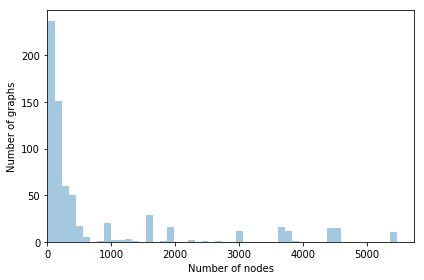

In [8]:
sns.distplot([g.number_of_nodes() for g in amd_df['networkx:graph']], kde=False)
plt.xlabel('Number of nodes')
plt.ylabel('Number of graphs')
plt.xlim((0, None))
viz.finalise()

### Number of edges in FFGs

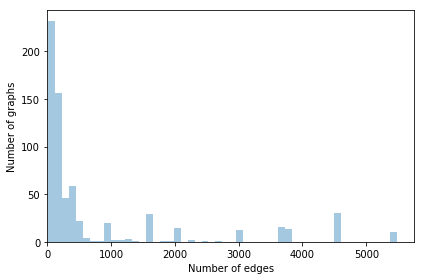

In [9]:
sns.distplot([g.number_of_edges() for g in amd_df['networkx:graph']], kde=False)
plt.xlabel('Number of edges')
plt.ylabel('Number of graphs')
plt.xlim((0, None))
viz.finalise()

### CFG Diameters

1535
977
138
43
72
481
1507
57
2279
67
1684
408
70
70
977
30
54
55
47
62
204
1781
237
1535
1507
91
62
81
1507
81
61
237
58
29
62
1684
209
72
237
1684
106
29
1684
11
1333
47
34
516
973
39
481
41
78
49
1684
55
35
1687
34
1687
94
1535
130
192
56
14
1507
100
143
71
11
481
90
100
192
481
67
1535
139
204
94
70
68
146
30
40
99
160
481
34
2573
54
809
30
481
1684
481
55
30
90
138
40
1535
81
58
1687
44
56
41
516
87
50
2553
244
54
100
34
32
99
139
91
55
17
204
2553
42
58
94
937
146
99
359
30
30
14
37
157
89
965
1687
55
17
191
38
1684
45
57
809
78
99
1687
45
1684
77
56
192
130
167
261
74
481
59
205
62
139
56
204
91
51
61
107
1687
71
100
72
51
41
34
62
456
44
110
68
291
58
30
64
164
37
74
300
3636
42
46
70
62
139
91
481
37
24
89
204
1507
120
61
62
68
69
54
1684
54
47
100
130
61
300
481
1237
1648
100
143
62
204
456
72
237
62
1684
456
29
89
65
1535
62
67
100
193
84
481
456
61
1687
192
160
89
419
117
89
61
14
77
89
54
68
68
46
55
1535
204
329
47
244
54
516
47
204
138
513
36
54
72
138
110
204
130
69
77

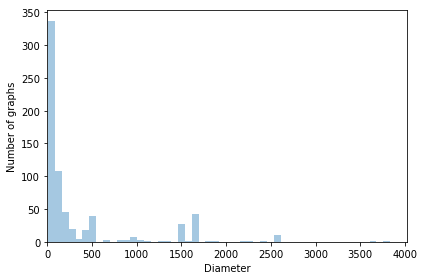

In [15]:
def Diam(g):
    d = nx.diameter(g.to_undirected())
    print(d)
    return d

diameters = [Diam(g) for g in amd_df['networkx:graph']]
sns.distplot(diameters, kde=False)
plt.xlabel('Diameter')
plt.ylabel('Number of graphs')
plt.xlim((0, None))
viz.finalise()

### Draw graph shapes

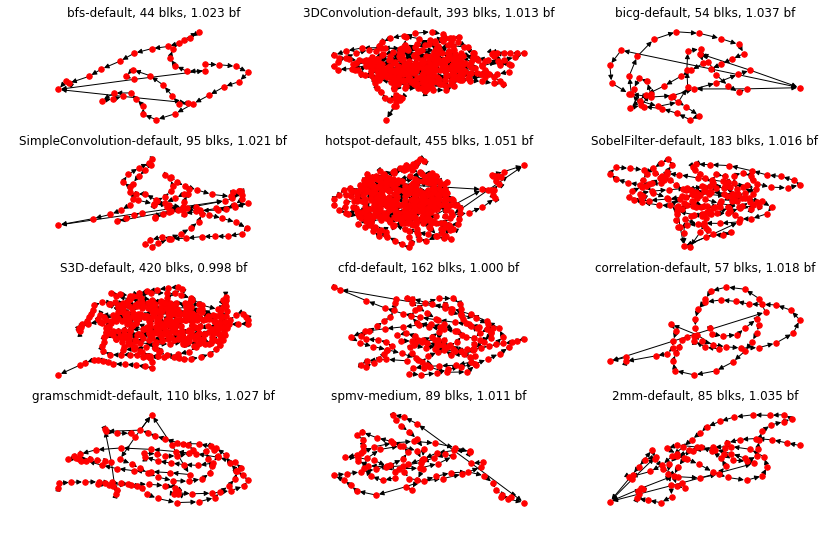

In [11]:
num_plots = (4, 3)

# Random state used to select graphs to draw, and controlling layout of graphs.
seed = 0xCEC

fig = plt.figure(figsize=(int(3.5 * num_plots[0]), int(3.2 * num_plots[1])))
fig.clf()

benchmarks = list(set(amd_df['program:benchmark_name']))

rand = np.random.RandomState(seed=seed)
rand.shuffle(benchmarks)

for j in range(num_plots[0]):
    for i in range(num_plots[1]):
        ax_index = ((j * num_plots[1]) + i) + 1
        ax = fig.add_subplot(*num_plots, ax_index)
        benchmark_name = benchmarks[ax_index - 1]
        df_rows = amd_df[amd_df['program:benchmark_name'] == benchmark_name]
        df_row = rand.choice(df_rows.index)
        graph = amd_df['networkx:graph'][df_row]
        
        nx.draw_spring(graph, with_labels=False, node_size=30, ax=ax, random_state=rand)
        graph_name = '-'.join([amd_df['program:benchmark_name'][df_row],
                               amd_df['data:dataset_name'][df_row]])
        
        branch_factor = graph.number_of_edges() / graph.number_of_nodes()
        ax.set_title(f'{graph_name}, {graph.number_of_nodes()} blks, {branch_factor:.3f} bf',)

viz.finalise(tight=False)